It is logical to assume that two different wines with similar physicochemical properties should have a similar quality value.
I will use KNeighborsRegressor and GridSearchCV to find best estimator

In [1]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import StratifiedShuffleSplit

import utils
import metrics
import data_tools

Load data.<br>
Since KNeighborsRegressor uses a matrix of distances between the examples, the data must be scaled

In [2]:
seed = 1528
path2data = os.path.join('..', 'data', 'winequality-white.csv')
data =  data_tools.Data(path2data, seed)
data.scale()
x_train, y_train, x_test, y_test = data.get_train_test()

To estimate quality of model I will use:<br>
mean_average_error (mae)<br>
weighted_mae<br>
balanced_accuracy<br>
confusion matrix<br>

In [3]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
weighted_mae_scorer = make_scorer(metrics.weighted_mae, greater_is_better=False, class_weights=data.class_weights)
balanced_accuracy_scorer = make_scorer(metrics.balanced_accuracy_score, greater_is_better=True)

I will choose parameters of KNeighborsRegressor (n_neighbors, p, algorithm) using GridSearchCV with StratifiedShuffleSplit

In [4]:
model = GridSearchCV(KNeighborsRegressor(),
                     param_grid={'n_neighbors': [1, 2, 5, 10],
                                 'p': [1, 2],
                                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
                     scoring=mae_scorer,
                     cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed),
                     n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.567404 using {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
-0.618510 (0.014515) with: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
-0.622837 (0.018203) with: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
-0.594351 (0.006022) with: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 1}
-0.599038 (0.008745) with: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 2}
-0.573990 (0.004687) with: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
-0.574135 (0.007444) with: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2}
-0.567404 (0.006835) with: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
-0.569663 (0.006886) with: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2}
-0.618510 (0.014515) with: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1}
-0.622837 (0.018203) with: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
-0.594351 (0.006022) with: {'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 1}
-0.599038 (0.008745) with: {'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 2}
-0.5739

Accuracy does not depend on the algorithm


Train
MAE: 0.505123
Weighted MAE: 1.2488
Balanced accuracy score: 0.2502

Test
MAE: 0.564508
Weighted MAE: 1.2553
Balanced accuracy score: 0.2269
Confusion matrix:
 [[  0   0   2   4   0   0   0]
 [  0   0  23  23   0   0   0]
 [  0   0 162 183   8   0   0]
 [  0   0  70 417  50   0   0]
 [  0   0   6 128  73   0   0]
 [  0   0   0  21  18   0   0]
 [  0   0   0   0   1   0   0]]


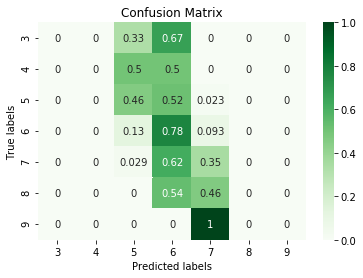

In [5]:
utils.print_metrics("Train", y_train, y_pred_train, data.classes, data.class_weights, draw_conf_matrix=False)
utils.print_metrics("Test", y_test, y_pred, data.classes, data.class_weights, draw_conf_matrix=True)

All predicted classes are in [5, 6, 7].<br>
Try using a metric that takes into account the imbalance of classes.

In [6]:
model = GridSearchCV(KNeighborsRegressor(algorithm='auto'),
                     param_grid={'n_neighbors': [1, 2, 5, 10],
                                 'p': [1, 2]},
                     scoring=weighted_mae_scorer,
                     cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed),
                     n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1.261001 using {'n_neighbors': 1, 'p': 2}
-1.321323 (0.262802) with: {'n_neighbors': 1, 'p': 1}
-1.261001 (0.126807) with: {'n_neighbors': 1, 'p': 2}
-1.347645 (0.186465) with: {'n_neighbors': 2, 'p': 1}
-1.329942 (0.153912) with: {'n_neighbors': 2, 'p': 2}
-1.374941 (0.131103) with: {'n_neighbors': 5, 'p': 1}
-1.357080 (0.130017) with: {'n_neighbors': 5, 'p': 2}
-1.377745 (0.123743) with: {'n_neighbors': 10, 'p': 1}
-1.391112 (0.111340) with: {'n_neighbors': 10, 'p': 2}



Train
MAE: 0.000000
Weighted MAE: 0.0000
Balanced accuracy score: 1.0000

Test
MAE: 0.613961
Weighted MAE: 1.1221
Balanced accuracy score: 0.2635
Confusion matrix:
 [[  0   3   1   2   0   0   0]
 [  0  10  21  12   3   0   0]
 [  0  13 177 143  18   2   0]
 [  0  12 112 297  96  20   0]
 [  0   0  23  77  92  15   0]
 [  0   0   2  17  15   5   0]
 [  0   0   0   0   1   0   0]]


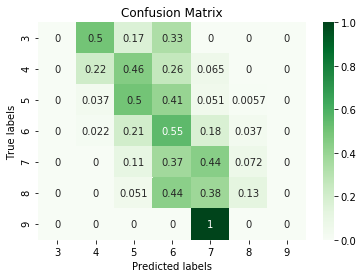

In [7]:
utils.print_metrics("Train", y_train, y_pred_train, data.classes, data.class_weights, draw_conf_matrix=False)
utils.print_metrics("Test", y_test, y_pred, data.classes, data.class_weights, draw_conf_matrix=True)

Best: 0.261643 using {'n_neighbors': 1, 'p': 2}
0.258452 (0.008429) with: {'n_neighbors': 1, 'p': 1}
0.261643 (0.013784) with: {'n_neighbors': 1, 'p': 2}
0.237719 (0.013315) with: {'n_neighbors': 2, 'p': 1}
0.236337 (0.016413) with: {'n_neighbors': 2, 'p': 2}
0.233231 (0.007272) with: {'n_neighbors': 5, 'p': 1}
0.234929 (0.009190) with: {'n_neighbors': 5, 'p': 2}
0.222217 (0.005644) with: {'n_neighbors': 10, 'p': 1}
0.226958 (0.005044) with: {'n_neighbors': 10, 'p': 2}

Train
MAE: 0.000000
Weighted MAE: 0.0000
Balanced accuracy score: 1.0000

Test
MAE: 0.613961
Weighted MAE: 1.1221
Balanced accuracy score: 0.2635
Confusion matrix:
 [[  0   3   1   2   0   0   0]
 [  0  10  21  12   3   0   0]
 [  0  13 177 143  18   2   0]
 [  0  12 112 297  96  20   0]
 [  0   0  23  77  92  15   0]
 [  0   0   2  17  15   5   0]
 [  0   0   0   0   1   0   0]]


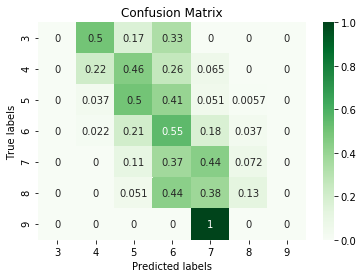

In [8]:
model = GridSearchCV(KNeighborsRegressor(algorithm='auto'),
                     param_grid={'n_neighbors': [1, 2, 5, 10],
                                 'p': [1, 2]},
                     scoring=balanced_accuracy_scorer,
                     cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed),
                     n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
utils.print_metrics("Train", y_train, y_pred_train, data.classes, data.class_weights, draw_conf_matrix=False)
utils.print_metrics("Test", y_test, y_pred, data.classes, data.class_weights, draw_conf_matrix=True)

weighted_mae and balanced_accuracy show the same result and it better then using mae.<br>
The excellent result in the training sample is explained by the fact that the model uses only one neighbor to determine the value of the quality of the wine. And in the training set, the closest element will be this element itself.

Let's remove features that do not correlate with quality.<br>
I removed different combinations of 'citric acid', 'free sulfur dioxide', 'sulphates'. 
Best result when only 'citric acid' was removed

Best: 0.262860 using {'n_neighbors': 1, 'p': 2}
0.260322 (0.010801) with: {'n_neighbors': 1, 'p': 1}
0.262860 (0.010648) with: {'n_neighbors': 1, 'p': 2}
0.239488 (0.007629) with: {'n_neighbors': 2, 'p': 1}
0.240145 (0.011000) with: {'n_neighbors': 2, 'p': 2}
0.230839 (0.007254) with: {'n_neighbors': 5, 'p': 1}
0.229685 (0.006248) with: {'n_neighbors': 5, 'p': 2}
0.216822 (0.005069) with: {'n_neighbors': 10, 'p': 1}
0.219378 (0.004868) with: {'n_neighbors': 10, 'p': 2}

Train
MAE: 0.000000
Weighted MAE: 0.0000
Balanced accuracy score: 1.0000

Test
MAE: 0.604710
Weighted MAE: 1.1020
Balanced accuracy score: 0.2676
Confusion matrix:
 [[  0   3   1   2   0   0   0]
 [  0  10  23  11   2   0   0]
 [  0  11 184 138  18   2   0]
 [  0   8 127 288  99  14   1]
 [  0   1  21  80  92  13   0]
 [  0   0   2  16  15   6   0]
 [  0   0   0   0   1   0   0]]


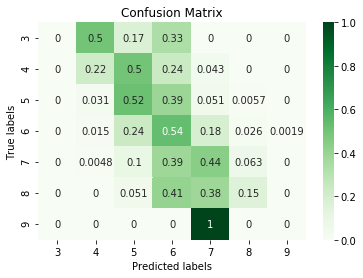

In [9]:
data =  data_tools.Data(path2data, seed, drop_features=['citric acid'])
data.scale()
x_train, y_train, x_test, y_test = data.get_train_test()
model = GridSearchCV(KNeighborsRegressor(algorithm='auto'),
                     param_grid={'n_neighbors': [1, 2, 5, 10],
                                 'p': [1, 2]},
                     scoring=balanced_accuracy_scorer,
                     cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed),
                     n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
utils.print_metrics("Train", y_train, y_pred_train, data.classes, data.class_weights, draw_conf_matrix=False)
utils.print_metrics("Test", y_test, y_pred, data.classes, data.class_weights, draw_conf_matrix=True)

Save best model

In [10]:
from joblib import dump
dump(model, os.path.join('..', 'models', 'knn.joblib'))

['..\\models\\knn.joblib']